In [48]:
import numpy as np
from numpy import sin,cos,tan,exp
from math import pi
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import clear_output
from time import sleep
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import SimulatedBinaryCrossover
from pymoo.algorithms.moo.nsga2 import PolynomialMutation
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.optimize import fsolve
sns.set()

def ratio(alp,bet,psi,N):
    '''
    Esta función calcula ratio de area que se queda oculta al sol debido 
    a la sombra de la placa anterior. Los parametros de la función son:
    
        alp: es el angulo de la primera placa respecto a la tierra
        bet: es el angulo de la segunda placa respecto a la tierra
        psi: angulo del sol respecto a la tierra
        N: multiplos de la longitud de separacion entre placas (s), 
           s es el numero de placas que hay entre la placa que da 
           la sombra y la recibe 
    '''
    
    #se pasan los angulos a radianes.
    bet,alp,psi = conv*bet,conv*alp,conv*psi
    
    
    # determinación del punto bajo de la placa
    xb = -0.5*A*cos(bet) + N*s
    yb = -0.5*A*sin(bet) + h
    B = [xb,yb]
    
    
    # calculo del punto de colisión de la sombra de la placa anterior con la placa siguiente
    xp = (0.5*A*(sin(alp) + cos(alp)*tan(psi)) + N*s*tan(bet) + (N-1)*s*tan(psi))/(tan(bet) + tan(psi))
    yp = tan(bet)*(xp - N*s) + h
    P = [xp ,yp]
    
    #distancia entre ambos puntos
    d = np.sqrt((P[0] - B[0])**2 + (P[1] - B[1])**2)
    
    # ratio entre la distancia de la sombra respecto longitud de la celda.
    R = d/c
    
    
    # si la sombra no toca la placa, el ratio es negativo (lo que hara maxima la generación)
    if (P[0] < B[0]):
        R = -d/c
    
    # se devuelve el ratio
    return R

def SxA(alp,ps):
    '''
    Producto escalar entre el angulo del sol (ps)
    y el angulo de la placa (alp)
    '''
    # conversion de grados a radianes
    alp,ps = alp*conv,ps*conv    
    
    # calculo del producto escalar
    return sin(alp)*cos(ps) + cos(alp)*sin(ps)

def potencia_rat(R,alp,ps):
    '''
    calcula la potencia de la placa en función del
    ratio de sombra de la placa, la eficicencia de
    la placa fija (eta), el angulo entren placas
    y otros parámetros relacionados con el entorno
    (alp,ps)
    '''
    # gamma: funcion que se hace 0 o 1, dependiendo del grado de sombra
    G = np.min([1,np.max([0,1-R])])*0.999 + 0.001
    
    #potencia generada.
    P = eta*I0*G*A*SxA(alp,ps)*exp(-a/sin(ps*conv))
    return P


def potencia_rat_temp(R,alp,ps,T):
    '''
    esta función es igualq ue la anterior pero
    tiene en cuenta la perdida de eficiencia provocada
    por la temperatura de las placas, de forma que es necesario
    calcular el aumento de temperatura debido a la radiación solar.
    
    los valores numéricos que aparecen son parámetros a determinar 
    y son distintos para cada tipo de placa, latitud etc.
    ''' 
    
    #aumento de la temperatura de la celula 
    Tcell = T + 0.125*I0*exp(-a/sin(ps*conv))*sin(conv*ps + conv*alp) + 273
    
    # eficiencia de la placa en función del aumento de temperatura
    eta = 0.9582*(1 - 0.004481290611696169*(Tcell-290))
    
    # gamma: funcion que se hace 0 o 1, dependiendo del grado de sombra
    G = np.min([1,np.max([0,1-R])])*0.999 + 0.001
    
    #potencia generada.
    P = eta*I0*G*A*SxA(alp,ps)*exp(-a/sin(ps*conv))
    return P

def coste(alp):
    '''
    calculo de todas las sombras entre placas y potencia 
    de una configuración de placas:
    
        alp: vector de configuración de angulos entre placas
    
    '''
    
    # en este bucle se calculan los ratios que sombrea una placa
    # con las siguientes,se elimina la posibilidad de que una placa
    # de sombra a ella misma y que una placa de sombra a la anterior.
    I,J = [0],[0]
    R = [0]
    for i in range(len(alp)-1):
        for j in range(i+1,len(alp)):
            R.append(ratio(alp[i],alp[j],ps,(j-i)))
            I.append(i)
            J.append(j)

    ratios = pd.DataFrame({'i':I,'j':J,'S':R})
    jun = np.unique(ratios.j)
    rt = []
    
    # nos quedamos con los ratios de sombra más altos
    # de cada placa, es decir, la sombra más alta,
    # que es la que cuenta.
    for j in jun:
        rt.append(np.max(ratios[ratios.j == j].S))

    # se suman las potencias de cada placa (negativas para minimizar 
    # para encontrar el minimo)
    P = 0
    for k in range(len(alp)):
        P += potencia_rat_temp(rt[k],alp[k],ps,T)
    return -P


def coste_(alp):
    '''
    la función anterior pero agregando en lista para 
    observar el proceso de optimización.
    '''
    I,J = [0],[0]
    R = [0]
    for i in range(len(alp)-1):
        for j in range(i+1,len(alp)):
            R.append(ratio(alp[i],alp[j],ps,(j-i)))
            I.append(i)
            J.append(j)

    ratios = pd.DataFrame({'i':I,'j':J,'S':R})
    jun = np.unique(ratios.j)
    rt = []
    for j in jun:
        rt.append(np.max(ratios[ratios.j == j].S))

    # P = 0
    P = []
    for k in range(len(alp)):
        P.append(potencia_rat(rt[k],alp[k],ps))
    return P


def plot_placa_(alpha,N,phi):
    '''
    función para graficar las placas con optimizacion
    '''
    alpha = alpha*conv
    phi = phi*conv
    plt.vlines(x=N*s, ymin=0, ymax=h, linewidth=2, color='black')
    
    x = np.linspace(-0.5*A*cos(alpha),0.5*A*cos(alpha),100)     
    y_ = tan(alpha)*x + h
    
    plt.plot(x+N*s,y_, linewidth=2, color='black')
    
    x_ = np.linspace(-100,100,100)
    
    plt.plot(x_ + N*s ,
             -tan(phi)*x_ + y_[-1] + tan(phi)*x[-1],
             linewidth=2, 
             color='orange',alpha = 0.3)
    
def plot_placa_mal(alpha,N,phi):
    '''
    función para graficar las placas sin optimizacion 
    '''
    alpha = alpha*conv
    phi = phi*conv
    plt.vlines(x=N*s, ymin=0, ymax=h, linewidth=2, color='grey')
    
    x = np.linspace(-0.5*A*cos(alpha),0.5*A*cos(alpha),100)     
    y_ = tan(alpha)*x + h
    
    plt.plot(x+N*s,y_, linewidth=2, color='grey',alpha = 0.5)
    
    # x_ = np.linspace(-100,100,100)
    
    # plt.plot(x_ + N*s ,
    #          -tan(phi)*x_ + y_[-1] + tan(phi)*x[-1],
    #          linewidth=2, 
    #          color='orange',alpha = 0.3)

def ang_max(p):
    '''
    calculo del angulo a partir del cual dejan de tener efecto 
    las sombras entre placas (de momento no se usa)
    '''
    f = s*tan(p*conv) - A*cos(p*conv)
    return f
p_max = fsolve(ang_max,0)[0] + 10

In [19]:
mu = 0
variance = 0.1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 180)
Temp = 30*stats.norm.pdf(x, mu, sigma)

algorithm = GA(pop_size=500,
                  sampling=get_sampling('int_random'),
                  crossover=get_crossover("int_sbx", prob=0.9, eta=20),
                  mutation=get_mutation("int_pm"),
                  eliminate_duplicates=True)

termination = MultiObjectiveSpaceToleranceTermination(tol=0.001,
                                                      n_last=100,
                                                      nth_gen=5,
                                                      n_max_gen=1e14,
                                                      n_max_evals=None)

In [20]:
n_placas = 10

conv = 2*pi/360
A = 2 #longitud de la placa 
c = A/10
s = 4 # separacion de placas
h = 2 # altura de las placas

a = 0.5 #factor de reduccion del aire
I0 = 100 #constante solar 
# eta = 0.9 #eficiencia de la placa

In [21]:
alp = []


# for ps in np.arange(1,10,1):
#     print(ps)
#     T = Temp[ps]
#     ang_mal = np.repeat(90-ps, n_placas)
#     ang_mal[ang_mal > 80] = 80
#     alp.append(ang_mal)


# for ps in np.arange(10,int(p_max),1):
for ps in np.arange(1,89,1):
    # inicio = time.time()
#     a_min = 90 - ps
#     if a_min >= 80:
#         a_min = 79
#     a_min -= 20
   
    T = Temp[ps]
    xl = np.repeat(0,n_placas)
    xu = np.repeat(81,n_placas)
    print(ps)
    problem = FunctionalProblem(n_placas,coste,xl=xl,xu=xu)
    res = minimize(problem,
                   algorithm,
                   termination=termination,
                   seed=123,
                   save_history=False)
    fin = time.time()
    # print(ps,fin - inicio)
    
    alp.append(res.X)
    
    
# for ps in np.arange(int(p_max),89,1):
#     print(ps)
#     T = Temp[ps]
#     ang_mal = np.repeat(90-ps, n_placas)
#     ang_mal[ang_mal > 80] = 80
#     alp.append(ang_mal)
# print(coste(alp))
# plt.figure(figsize = (18,6))
# plt.axhline(y=0, color='black', linestyle='-')
# for i in range(len(alp)):
#     plot_placa_(alp[i],i,ps)
# plt.ylim([0,5])
# plt.xlim([-2.5,A + (len(alp)-1)*s])
# plt.show()

1
1 245.2415759563446
2
2 243.76515889167786
3
3 244.58969950675964
4
4 241.15882563591003
5
5 242.41312098503113
6
6 241.3568058013916
7
7 259.0353021621704
8
8 256.1762480735779
9
9 251.2669997215271
10
10 250.02659940719604
11
11 331.7519464492798
12
12 320.2188868522644
13
13 316.942813873291
14
14 316.6305706501007
15
15 307.0447497367859
16
16 295.3108105659485
17
17 293.8775408267975
18
18 294.3638758659363
19
19 282.3937165737152
20
20 304.45441246032715
21
21 281.6912741661072
22
22 290.3519186973572
23
23 273.35680198669434
24
24 272.92897605895996
25
25 265.44504165649414
26
26 274.9916751384735
27
27 265.56887197494507
28
28 267.25049686431885
29
29 262.9187116622925
30
30 273.70837569236755
31
31 276.22552466392517
32
32 266.0533092021942
33
33 266.0478103160858
34
34 263.37411618232727
35
35 263.8566336631775
36
36 274.9016020298004
37
37 274.7628481388092
38
38 273.45555329322815
39
39 273.1074380874634
40
40 278.0266840457916
41
41 278.8466441631317
42
42 268.7280466556

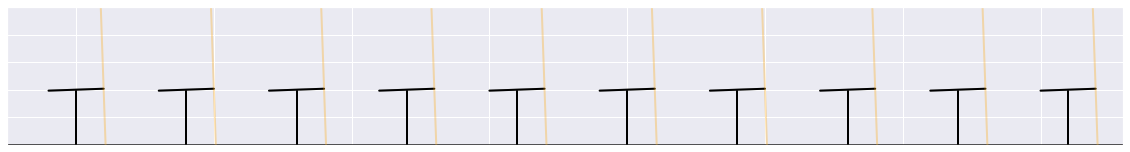

In [45]:
C = []
C_mal = []

for i,ps in enumerate(np.arange(1,89,1)):
    fig, ax = plt.subplots()
    # fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.axhline(y=0, color='black', linestyle='-')
    ang_mal = np.repeat(90-ps, len(alp[i]))
    ang_mal[ang_mal > 80] = 80
    for j in range(len(alp[i])):
        aa = alp[i]
        plot_placa_mal(ang_mal[j],j,ps)
        plot_placa_(aa[j],j,ps)
        
    C_mal.append(-coste(ang_mal))
    C.append(-coste(alp[i]))
    # print(ps)
    ax.set_ylim([0,5])
    ax.set_xlim([-2.5,A + (len(alp[i])-1)*s])
    
    ax.set_aspect(1)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.savefig("animated_10/"+ str(ps) + ".png")
    plt.show()
    # sleep(0.3)
    clear_output(wait=True)

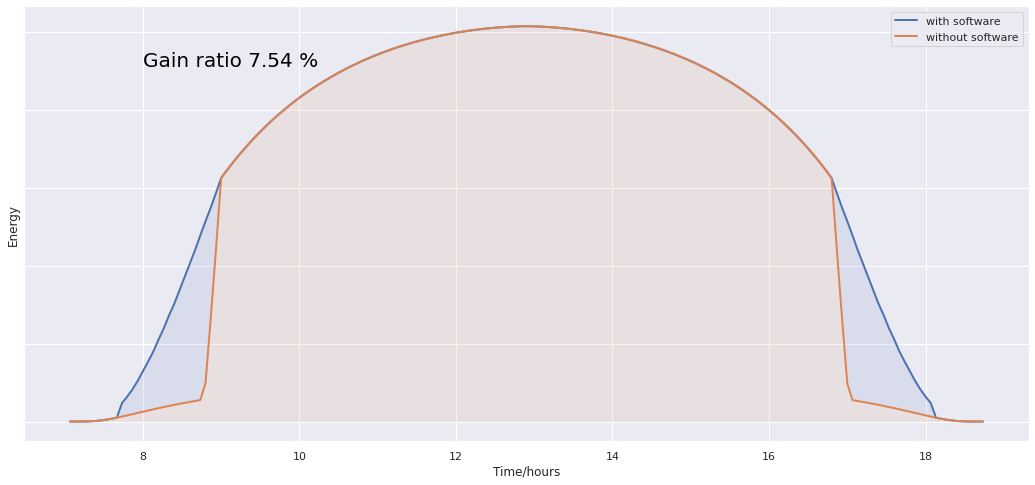

In [40]:
plt.figure(figsize = (18,8))
plt.plot(np.arange(1,177,1)*(24/360)+7,
         np.concatenate((np.array(C), np.array(C[::-1])), axis=0),
         label = "with software",linewidth=2)
plt.fill_between(np.arange(1,177,1)*(24/360)+7,
                 np.concatenate((np.array(C_mal), np.array(C_mal[::-1])), axis=0),
                 np.concatenate((np.array(C), np.array(C[::-1])), axis=0),alpha = 0.1)

plt.text(8, max(np.concatenate((np.array(C_mal), np.array(C_mal[::-1])), axis=0))*0.9, 
         'Gain ratio '+ str(round((np.sum(C)/np.sum(C_mal) -1 )*100,2)) + ' %', fontsize=20, color='black')
plt.plot(np.arange(1,177,1)*(24/360)+7,
         np.concatenate((np.array(C_mal), np.array(C_mal[::-1])), axis=0),
         label = "without software",linewidth=2)


plt.fill_between(np.arange(1,177,1)*(24/360)+7,
                 np.concatenate((np.array(C_mal), np.array(C_mal[::-1])), axis=0),
                 alpha = 0.1)
plt.legend()
plt.ylabel("Energy")
plt.xlabel("Time/hours")
# plt.ylim([0,600])
plt.tick_params(left = False, right = False , labelleft = False)
plt.savefig("grafica_10.pdf")
plt.show()

In [41]:
pd.DataFrame({
    'ps': np.arange(1,177,1),
    'alp':list(np.concatenate((np.array(alp), np.array(alp[::-1])), axis=0)),
    'C':np.concatenate((np.array(C), np.array(C[::-1])), axis=0),
    'C_no_soft':np.concatenate((np.array(C_mal), np.array(C_mal[::-1])), axis=0)
}).to_csv("angulos_result_10.csv",index = False)